In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from poisson_glm_granger import compute_granger_causality, permutation_test, filter_indirect_connections
from joblib import Parallel, delayed
from scipy.stats import spearmanr

from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

Source 0 -> Target 0: Optimal window = 1, CV score = -0.6589
Source 1 -> Target 0: Optimal window = 18, CV score = -0.6817
Source 2 -> Target 0: Optimal window = 18, CV score = -0.6816
Source 0 -> Target 1: Optimal window = 1, CV score = -0.6023
Source 1 -> Target 1: Optimal window = 1, CV score = -0.6930
Source 2 -> Target 1: Optimal window = 2, CV score = -0.6926
Source 0 -> Target 2: Optimal window = 2, CV score = -0.4305
Source 1 -> Target 2: Optimal window = 1, CV score = -0.3318
Source 2 -> Target 2: Optimal window = 3, CV score = -0.4444


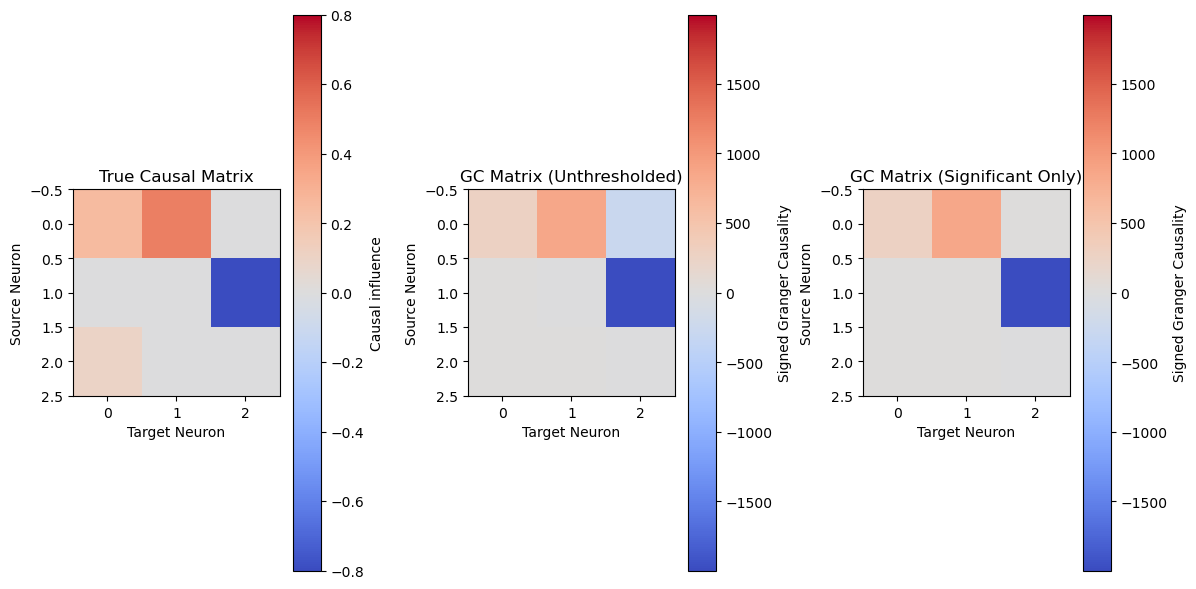

Granger Causality Matrix (Unthresholded):
[[2.76699072e+02 8.47387659e+02 2.75379383e+02]
 [3.44580588e+00 9.85926270e-01 1.99774700e+03]
 [2.56480565e+00 7.69629526e+00 1.43839200e+01]]
signed Granger Causality Matrix (Unthresholded):
[[ 2.76699072e+02  8.47387659e+02 -2.75379383e+02]
 [ 3.44580588e+00 -9.85926270e-01 -1.99774700e+03]
 [ 2.56480565e+00  7.69629526e+00 -1.43839200e+01]]

Significant Granger Causality Matrix:
[[  276.69907185   847.38765898     0.        ]
 [    3.44580588     0.         -1997.74700477]
 [    2.56480565     7.69629526   -14.38391997]]
Spearman rho=0.806694677384826, p=0.00860637673993241


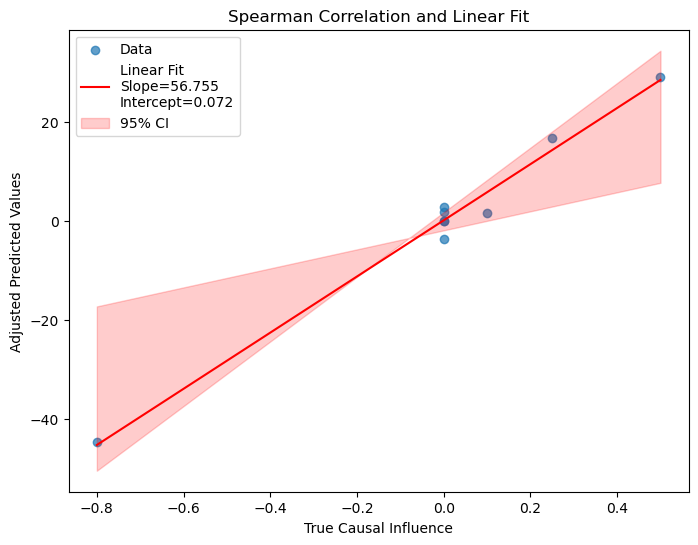

In [2]:
# Function to generate synthetic spike train data for trials
def generate_synthetic_spike_data_trials(neurons, trials, time_steps, causal_matrix, base_rate=0.01, noise_level=0.1):
    data = np.zeros((neurons, trials, time_steps))
    for trial in range(trials):
        for t in range(1, time_steps):
            for i in range(neurons):
                firing_rate = base_rate
                for j in range(neurons):
                    if causal_matrix[j, i] != 0:
                        firing_rate += causal_matrix[j, i] * data[j, trial, t - 1]
                firing_prob = max(0, min(1, firing_rate + np.random.normal(0, noise_level)))
                data[i, trial, t] = 1 if np.random.rand() < firing_prob else 0
    return data

# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.25, 0.5, 0.0],
    [0.0, 0.0, -0.8],
    [0.1, 0.0, 0.0]
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=3, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
best_windows, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    window_range=(1, 20), 
    folds=10
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    simulated_data_trials,
    best_windows,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    best_windows,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')


Source 0 -> Target 0: Optimal window = 1, CV score = -0.6594
Source 1 -> Target 0: Optimal window = 1, CV score = -0.6841
Source 2 -> Target 0: Optimal window = 1, CV score = -0.6833
Source 0 -> Target 1: Optimal window = 1, CV score = -0.5991
Source 1 -> Target 1: Optimal window = 1, CV score = -0.6918
Source 2 -> Target 1: Optimal window = 2, CV score = -0.6926
Source 0 -> Target 2: Optimal window = 2, CV score = -0.3853
Source 1 -> Target 2: Optimal window = 1, CV score = -0.3044
Source 2 -> Target 2: Optimal window = 1, CV score = -0.3921


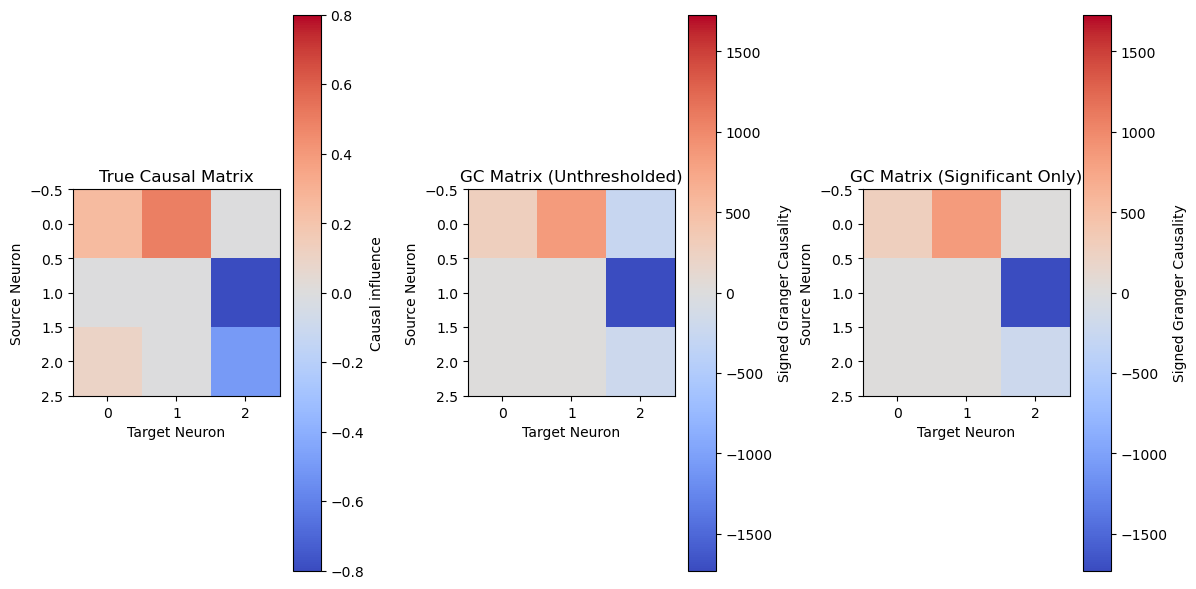

Granger Causality Matrix (Unthresholded):
[[2.74132121e+02 8.48258152e+02 2.57423149e+02]
 [4.52353488e-05 6.79241860e-01 1.72954868e+03]
 [1.18844457e+01 4.04100163e+00 2.03293920e+02]]
signed Granger Causality Matrix (Unthresholded):
[[ 2.74132121e+02  8.48258152e+02 -2.57423149e+02]
 [ 4.52353488e-05  6.79241860e-01 -1.72954868e+03]
 [ 1.18844457e+01  4.04100163e+00 -2.03293920e+02]]

Significant Granger Causality Matrix:
[[  274.13212127   848.25815179     0.        ]
 [    0.             0.         -1729.54868319]
 [   11.88444566     0.          -203.29391978]]
Spearman rho=1.0, p=0.0


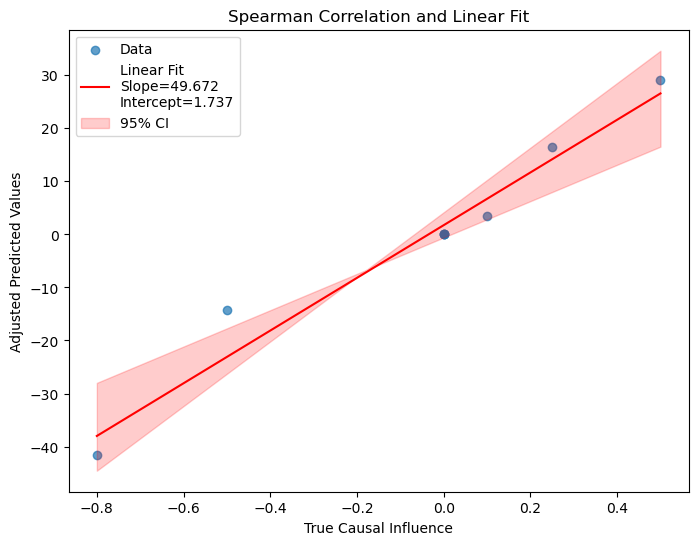

In [3]:
# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.25, 0.5, 0.0],
    [0.0, 0.0, -0.8],
    [0.1, 0.0, -0.5]
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=3, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
best_windows, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    window_range=(1, 20), 
    folds=10
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    simulated_data_trials,
    best_windows,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    best_windows,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')


Source 0 -> Target 0: Optimal window = 8, CV score = -0.6766
Source 1 -> Target 0: Optimal window = 2, CV score = -0.6743
Source 2 -> Target 0: Optimal window = 1, CV score = -0.6640
Source 3 -> Target 0: Optimal window = 20, CV score = -0.6765
Source 0 -> Target 1: Optimal window = 1, CV score = -0.6523
Source 1 -> Target 1: Optimal window = 1, CV score = -0.6850
Source 2 -> Target 1: Optimal window = 2, CV score = -0.6847
Source 3 -> Target 1: Optimal window = 1, CV score = -0.6851
Source 0 -> Target 2: Optimal window = 2, CV score = -0.6845
Source 1 -> Target 2: Optimal window = 1, CV score = -0.5919
Source 2 -> Target 2: Optimal window = 3, CV score = -0.6924
Source 3 -> Target 2: Optimal window = 20, CV score = -0.6923
Source 0 -> Target 3: Optimal window = 3, CV score = -0.6915
Source 1 -> Target 3: Optimal window = 2, CV score = -0.6810
Source 2 -> Target 3: Optimal window = 1, CV score = -0.6296
Source 3 -> Target 3: Optimal window = 10, CV score = -0.6929


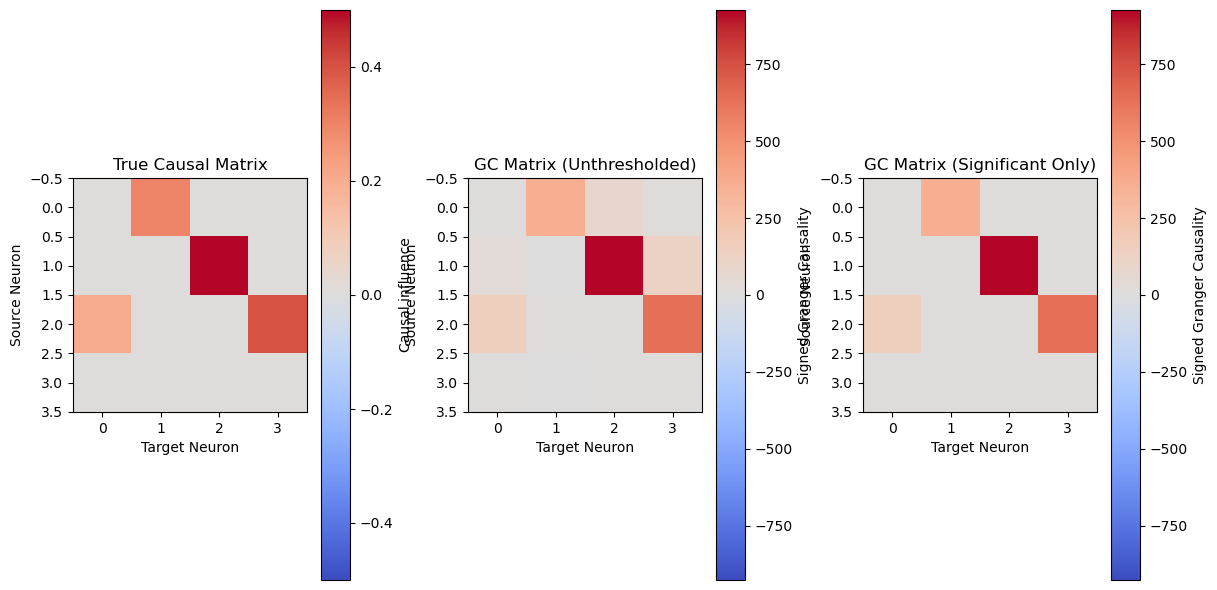

Granger Causality Matrix (Unthresholded):
[[4.82337648e+00 3.56585386e+02 7.60411602e+01 1.75158090e+01]
 [3.10993532e+01 1.19856272e-01 9.25438409e+02 1.18720155e+02]
 [1.51380269e+02 8.24733239e+00 2.08224664e+00 6.31044478e+02]
 [2.61048806e+00 3.81817762e-01 2.46508625e+00 3.83231481e+00]]
signed Granger Causality Matrix (Unthresholded):
[[ 4.82337648e+00  3.56585386e+02  7.60411602e+01  1.75158090e+01]
 [ 3.10993532e+01 -1.19856272e-01  9.25438409e+02  1.18720155e+02]
 [ 1.51380269e+02  8.24733239e+00  2.08224664e+00  6.31044478e+02]
 [ 2.61048806e+00 -3.81817762e-01  2.46508625e+00  3.83231481e+00]]

Significant Granger Causality Matrix:
[[  4.82337648 356.58538605   0.           0.        ]
 [  0.           0.         925.43840869   0.        ]
 [151.38026946   0.           0.         631.04447785]
 [  2.61048806   0.           2.46508625   3.83231481]]
Spearman rho=0.8130644657733823, p=0.00012843559126144555


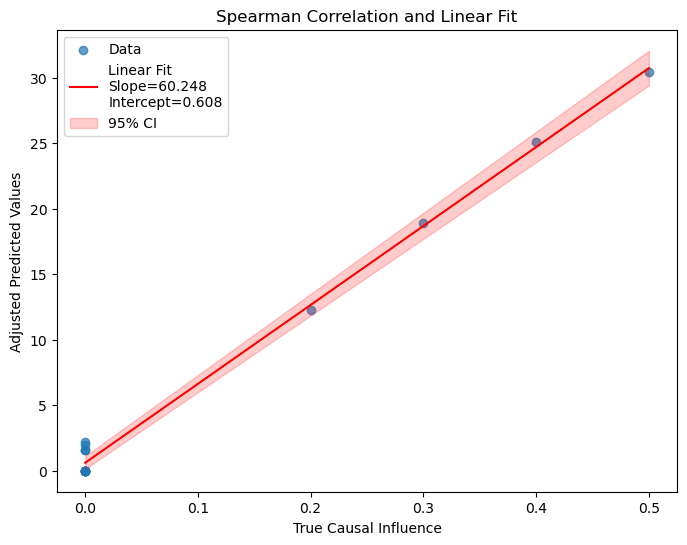

In [4]:
# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.0,  0.3, 0.0, 0.0],  # Neuron 0 causes Neuron 1
    [0.0,  0.0, 0.5, 0.0],  # Neuron 1 causes Neuron 2
    [0.2,  0.0, 0.0, 0.4],  # Neuron 2 causes Neurons 0 and 3
    [0.0,  0.0, 0.0, 0.0],  # Neuron 3 has no outgoing connections
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=4, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
best_windows, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    window_range=(1, 20), 
    folds=10
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    simulated_data_trials,
    best_windows,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    best_windows,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')


Source 0 -> Target 0: Optimal window = 11, CV score = -0.6773
Source 1 -> Target 0: Optimal window = 2, CV score = -0.6756
Source 2 -> Target 0: Optimal window = 1, CV score = -0.6615
Source 3 -> Target 0: Optimal window = 11, CV score = -0.6774
Source 4 -> Target 0: Optimal window = 12, CV score = -0.6773
Source 5 -> Target 0: Optimal window = 11, CV score = -0.6774
Source 0 -> Target 1: Optimal window = 1, CV score = -0.6308
Source 1 -> Target 1: Optimal window = 1, CV score = -0.6634
Source 2 -> Target 1: Optimal window = 2, CV score = -0.6613
Source 3 -> Target 1: Optimal window = 1, CV score = -0.6505
Source 4 -> Target 1: Optimal window = 1, CV score = -0.6633
Source 5 -> Target 1: Optimal window = 1, CV score = -0.6634
Source 0 -> Target 2: Optimal window = 1, CV score = -0.6819
Source 1 -> Target 2: Optimal window = 1, CV score = -0.6161
Source 2 -> Target 2: Optimal window = 1, CV score = -0.6916
Source 3 -> Target 2: Optimal window = 2, CV score = -0.6909
Source 4 -> Target 2

/home/bonaiuto/miniconda3/envs/poisson_glm_granger/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


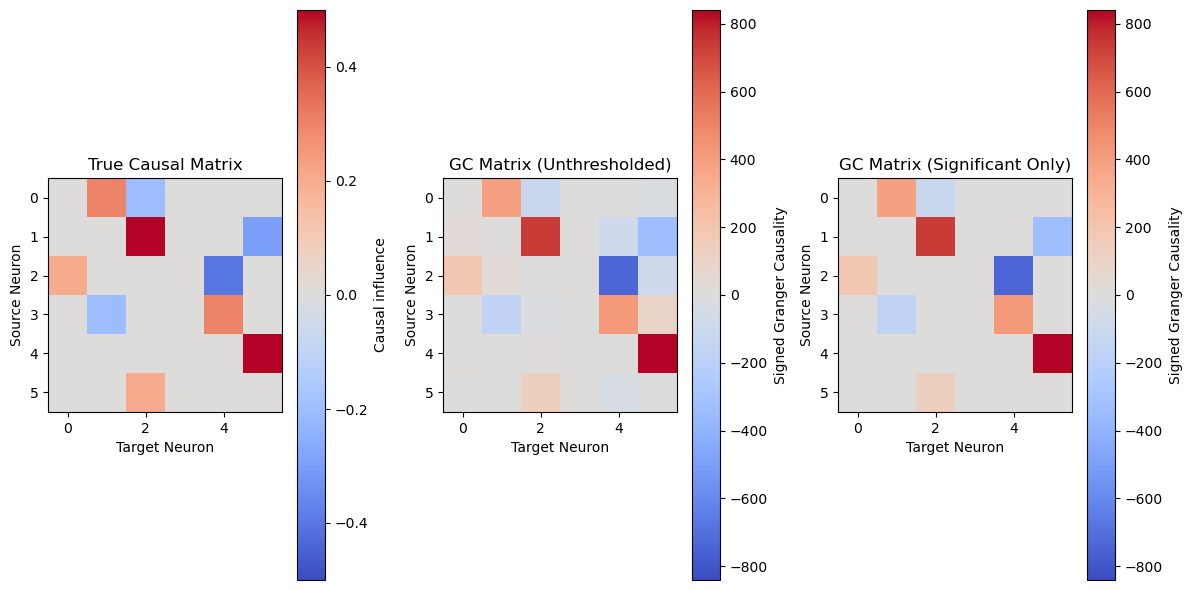

Granger Causality Matrix (Unthresholded):
[[6.46337745e-01 3.92646108e+02 1.14604346e+02 1.20706658e+00
  4.12291028e-01 2.32966154e+01]
 [2.77300684e+01 8.36365088e-01 7.37133065e+02 1.44951143e+00
  9.12105086e+01 3.30300440e+02]
 [1.83986923e+02 2.90019348e+01 2.35706542e-01 6.10423043e-01
  7.41065384e+02 8.66135478e+01]
 [4.52519089e-07 1.64276734e+02 1.45655176e+01 1.50187776e-01
  4.15032189e+02 9.35885711e+01]
 [1.95893400e+00 3.04387722e-03 1.08440572e+01 3.37384546e+00
  1.98685696e+00 8.40799478e+02]
 [3.77589532e-02 7.58523701e-01 1.29715753e+02 4.00970667e+00
  3.44826646e+01 3.31388556e-01]]
signed Granger Causality Matrix (Unthresholded):
[[ 6.46337745e-01  3.92646108e+02 -1.14604346e+02  1.20706658e+00
   4.12291028e-01 -2.32966154e+01]
 [ 2.77300684e+01  8.36365088e-01  7.37133065e+02  1.44951143e+00
  -9.12105086e+01 -3.30300440e+02]
 [ 1.83986923e+02  2.90019348e+01 -2.35706542e-01  6.10423043e-01
  -7.41065384e+02 -8.66135478e+01]
 [-4.52519089e-07 -1.64276734e+02 -

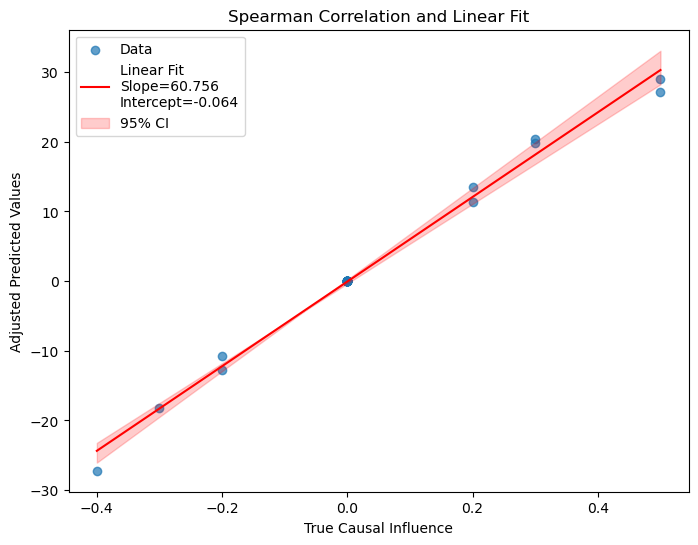

In [5]:
# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.0,  0.3, -0.2,  0.0,  0.0,  0.0],  # Neuron 0 excites Neuron 1, inhibits Neuron 2
    [0.0,  0.0,  0.5,  0.0,  0.0, -0.3],  # Neuron 1 excites Neuron 2, inhibits Neuron 5
    [0.2,  0.0,  0.0,  0.0, -0.4,  0.0],  # Neuron 2 excites Neuron 0, inhibits Neuron 4
    [0.0, -0.2,  0.0,  0.0,  0.3,  0.0],  # Neuron 3 inhibits Neuron 1, excites Neuron 4
    [0.0,  0.0,  0.0,  0.0,  0.0,  0.5],  # Neuron 4 excites Neuron 5
    [0.0,  0.0,  0.2,  0.0,  0.0,  0.0],  # Neuron 5 excites Neuron 2
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=6, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
best_windows, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    window_range=(1, 20), 
    folds=10
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    simulated_data_trials,
    best_windows,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    best_windows,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')


Source 0 -> Target 0: Optimal window = 2, CV score = -0.5531
Source 1 -> Target 0: Optimal window = 1, CV score = -0.5218
Source 2 -> Target 0: Optimal window = 2, CV score = -0.5566
Source 3 -> Target 0: Optimal window = 16, CV score = -0.5580
Source 4 -> Target 0: Optimal window = 16, CV score = -0.5580
Source 5 -> Target 0: Optimal window = 16, CV score = -0.5578
Source 6 -> Target 0: Optimal window = 16, CV score = -0.5579
Source 0 -> Target 1: Optimal window = 1, CV score = -0.5405
Source 1 -> Target 1: Optimal window = 2, CV score = -0.6019
Source 2 -> Target 1: Optimal window = 1, CV score = -0.5843
Source 3 -> Target 1: Optimal window = 3, CV score = -0.6148
Source 4 -> Target 1: Optimal window = 3, CV score = -0.6150
Source 5 -> Target 1: Optimal window = 2, CV score = -0.6141
Source 6 -> Target 1: Optimal window = 3, CV score = -0.6151
Source 0 -> Target 2: Optimal window = 1, CV score = -0.6656
Source 1 -> Target 2: Optimal window = 1, CV score = -0.6378
Source 2 -> Target 2

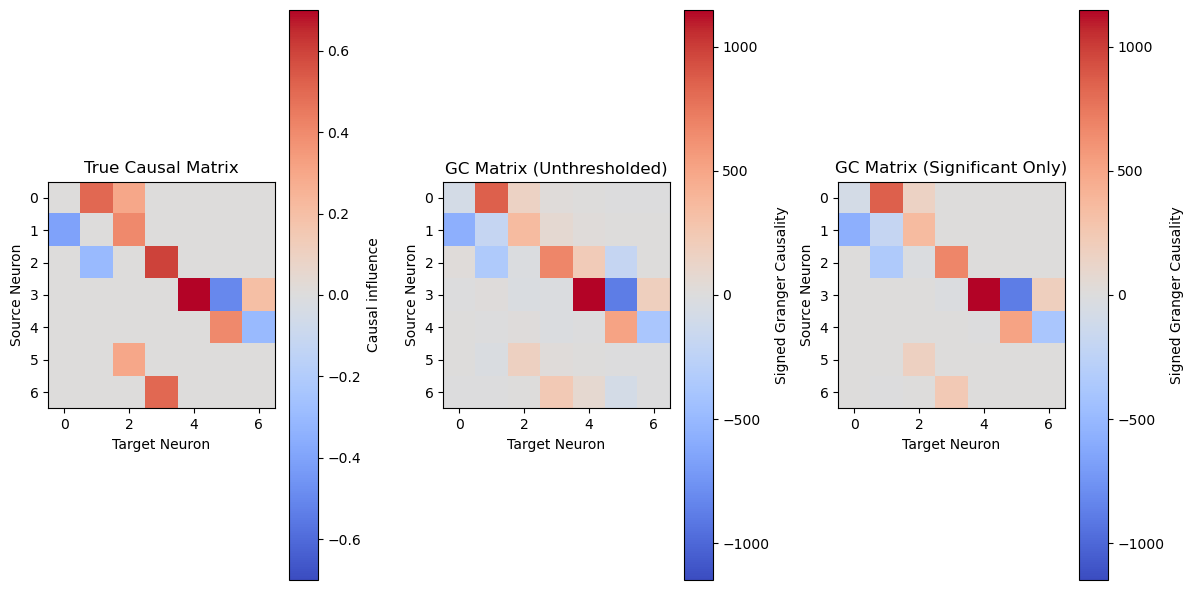

Granger Causality Matrix (Unthresholded):
[[7.58492539e+01 8.56817916e+02 1.50116001e+02 1.95269097e+01
  7.91197751e+00 1.72179366e+00 1.35151947e+00]
 [5.73149781e+02 1.92263851e+02 3.53487957e+02 6.60880325e+01
  1.96991449e+01 1.85573070e+00 3.41010335e-02]
 [2.36302760e+01 3.49145859e+02 2.49909210e+01 6.77404196e+02
  2.21211635e+02 1.90301882e+02 1.35441587e-01]
 [3.84639444e-01 9.97096623e+00 3.55222296e+01 2.60819169e+01
  1.14822269e+03 8.86445784e+02 1.84645723e+02]
 [3.13148783e-01 6.05671832e+00 1.55319137e+01 1.81627636e+01
  5.75754318e+00 5.12620979e+02 3.85142736e+02]
 [2.04881688e+00 2.72850809e+01 1.67757377e+02 2.01346334e+01
  5.70403876e+00 3.32220545e-02 7.82149612e-01]
 [2.57082541e-01 4.01393648e+00 2.67271844e-01 2.36464742e+02
  7.21713600e+01 7.99681867e+01 3.21021158e-01]]
signed Granger Causality Matrix (Unthresholded):
[[-7.58492539e+01  8.56817916e+02  1.50116001e+02  1.95269097e+01
   7.91197751e+00 -1.72179366e+00 -1.35151947e+00]
 [-5.73149781e+02 -1.

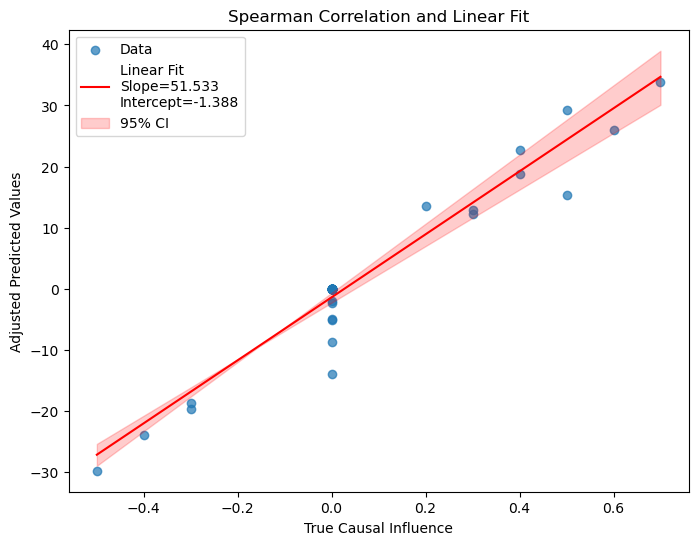

In [6]:
# Simulate synthetic spike train data for trials
causal_matrix = np.array([
    [0.0,  0.5,  0.3,  0.0,  0.0,  0.0,  0.0],  # Neuron 0 excites Neurons 1, 2
    [-0.4, 0.0,  0.4,  0.0,  0.0,  0.0,  0.0],  # Neuron 1 inhibits 0, excites 2
    [0.0, -0.3, 0.0,  0.6,  0.0,  0.0,  0.0],  # Neuron 2 inhibits 1, excites 3
    [0.0,  0.0,  0.0,  0.0,  0.7, -0.5,  0.2],  # Neuron 3 excites 4, inhibits 5, excites 6
    [0.0,  0.0,  0.0,  0.0,  0.0,  0.4, -0.3],  # Neuron 4 excites 5, inhibits 6
    [0.0,  0.0,  0.3,  0.0,  0.0,  0.0,  0.0],  # Neuron 5 excites 2
    [0.0,  0.0,  0.0,  0.5,  0.0,  0.0,  0.0],  # Neuron 6 excites 3
])
simulated_data_trials = generate_synthetic_spike_data_trials(
    neurons=7, trials=100, time_steps=100, causal_matrix=causal_matrix, base_rate=0.3, noise_level=0.3
)

# Analyze Granger causality with cross-validation
best_windows, gc_matrix, signed_gc_matrix = compute_granger_causality(
    simulated_data_trials, 
    window_range=(1, 20), 
    folds=10
)

# Filter indirect connections
filtered_gc_matrix, filtered_signed_gc_matrix = filter_indirect_connections(
    simulated_data_trials,
    best_windows,
    gc_matrix,
    signed_gc_matrix
)

# Perform permutation test
significant_gc_matrix, null_distribution, permuted_gc_matrices = permutation_test(
    best_windows,
    filtered_gc_matrix,
    filtered_signed_gc_matrix,
    simulated_data_trials,
    n_permutations=1000,
    n_jobs=4
)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
maxabs = np.max(np.abs(causal_matrix))
plt.imshow(causal_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Causal influence')
plt.title("True Causal Matrix")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 2)
maxabs = np.max(np.abs(signed_gc_matrix))
plt.imshow(signed_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Unthresholded)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.subplot(1, 3, 3)
maxabs = np.max(np.abs(significant_gc_matrix))
plt.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=(-maxabs, maxabs))
plt.colorbar(label='Signed Granger Causality')
plt.title("GC Matrix (Significant Only)")
plt.xlabel("Target Neuron")
plt.ylabel("Source Neuron")

plt.tight_layout()
plt.show()

# Print Granger causality matrix
print("Granger Causality Matrix (Unthresholded):")
print(gc_matrix)
print("signed Granger Causality Matrix (Unthresholded):")
print(signed_gc_matrix)
print("\nSignificant Granger Causality Matrix:")
print(significant_gc_matrix)


# Flatten the matrices
true_values = causal_matrix.flatten()
predicted_values = significant_gc_matrix.flatten()

adjusted_predicted_values=np.sign(predicted_values)*np.sqrt(np.abs(predicted_values))

# Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(true_values, adjusted_predicted_values)

# Bootstrapped confidence intervals for linear regression
bootstrapped_slopes = []
bootstrapped_intercepts = []
n_bootstraps = 1000
for _ in range(n_bootstraps):
    resampled_true, resampled_predicted = resample(true_values, adjusted_predicted_values)
    if not np.all(resampled_true==0):
        slope, intercept = np.polyfit(resampled_true, resampled_predicted, 1)
        bootstrapped_slopes.append(slope)
        bootstrapped_intercepts.append(intercept)

# Compute 95% CI
slope_ci = np.percentile(bootstrapped_slopes, [2.5, 97.5])
intercept_ci = np.percentile(bootstrapped_intercepts, [2.5, 97.5])

# Fit the linear regression line for plotting
slope, intercept = np.polyfit(true_values, adjusted_predicted_values, 1)
line_x = np.linspace(true_values.min(), true_values.max(), 100)
line_y = slope * line_x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(true_values, adjusted_predicted_values, alpha=0.7, label='Data')
plt.plot(line_x, line_y, color='red', label=f'Linear Fit\nSlope={slope:.3f}\nIntercept={intercept:.3f}')
plt.fill_between(line_x, slope_ci[0] * line_x + intercept_ci[0], slope_ci[1] * line_x + intercept_ci[1], 
                 color='red', alpha=0.2, label='95% CI')
plt.xlabel('True Causal Influence')
plt.ylabel('Adjusted Predicted Values')
plt.title('Spearman Correlation and Linear Fit')
plt.legend()

# Display Spearman results
print(f'Spearman rho={spearman_corr}, p={spearman_pval}')
